# ASR Dataset Quality Evaluation

Manual quality check of 100 randomly sampled transcriptions from the [dataset](https://huggingface.co/datasets/islomov/news_youtube_uzbek_speech_dataset). 
Evaluated Word Error Rate (WER), Character Error Rate (CER), and foreign language contamination.

**Methodology:**
1. Randomly sampled 100 audio files from the dataset
2. Extracted audio from parquet files using sample IDs
3. Manually verified and corrected transcriptions using custom HTML checker tool
4. Computed WER/CER metrics and foreign words count

In [1]:
import gc  # Garbage collector
import glob
import io
import os

import pandas as pd
import soundfile as sf
from tqdm import tqdm  # Progress bar library

SEED = 137
DATASET_DIR = "../datasets/it_youtube_uzbek_speech_dataset/data"
SAMPLED_AUDIO_DIR = os.path.join(DATASET_DIR, "sampled_audio")
ALL_DATA_PATH = os.path.join(DATASET_DIR, "dataset.csv")
SAMPLED_DATA_PATH = os.path.join(DATASET_DIR, "sampled.csv")
PROCESSED_AUDIO_STATS_PATH = os.path.join(DATASET_DIR, "processed_audio_stats.csv")
TRANSCRIPTION_RESULTS_PATH = os.path.join(DATASET_DIR, "google_spt_transcriptions.csv")
VALIDATION_TEST_SETS_PATH = os.path.join(DATASET_DIR, "validation_test_sets.csv")

### Create csv file with all data and computed statistics

In [2]:
def compute_statistics(df: pd.DataFrame, ignore_sampling_rate=True) -> dict:
    """Extract statistics without keeping audio in memory"""
    stats = {
        "id": [],
        "text_original": [],
        "path": [],
        "duration": [],
        "char_count": [],
        "word_count": [],
    }
    if not ignore_sampling_rate:
        stats["sampling_rate"] = []

    for i in range(len(df)):
        # Extract metadata
        stats["id"].append(df.iloc[i]["id"])
        stats["path"].append(df.iloc[i]["audio"]["path"])

        text = df.iloc[i]["text"]
        stats["text_original"].append(text)

        # Decode audio
        audio_bytes = df.iloc[i]["audio"]["bytes"]
        audio_array, sr = sf.read(io.BytesIO(audio_bytes))

        duration = len(audio_array) / sr
        stats["duration"].append(duration)
        stats["char_count"].append(len(text))
        stats["word_count"].append(len(text.split()))
        if not ignore_sampling_rate:
            stats["sampling_rate"].append(sr)

        # Clear audio from memory immediately
        del audio_bytes, audio_array

    return stats


parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")

all_data = []
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    df_partial = pd.read_parquet(parquet_file_path)

    stats = compute_statistics(df_partial)
    all_data.append(pd.DataFrame(stats))

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

# Combine all data
all_data_df = pd.concat(all_data, ignore_index=True)
del all_data  # Free memory
gc.collect()

all_data_df["id"] = all_data_df["id"].astype(int)
all_data_df.set_index("id", inplace=True)
all_data_df.to_csv(ALL_DATA_PATH)

Found 35 parquet files. Started processing...



Processing files: 100%|██████████| 35/35 [01:04<00:00,  1.84s/it]


In [3]:
all_data_df = pd.read_csv(ALL_DATA_PATH, index_col="id")

print(all_data_df.info())
print(all_data_df.describe())
print("\nFirst few rows:")
all_data_df

<class 'pandas.core.frame.DataFrame'>
Index: 21016 entries, 4809 to 20416
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text_original  21016 non-null  object 
 1   path           21016 non-null  object 
 2   duration       21016 non-null  float64
 3   char_count     21016 non-null  int64  
 4   word_count     21016 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 985.1+ KB
None
           duration    char_count    word_count
count  21016.000000  21016.000000  21016.000000
mean      25.814404    366.444566     48.978826
std        5.382347    115.622835     15.901813
min        2.989500      8.000000      1.000000
25%       23.877375    298.000000     39.000000
50%       28.080000    379.000000     50.000000
75%       29.744000    450.000000     60.000000
max       30.000062    714.000000    109.000000

First few rows:


,text_original,path,duration,char_count,word_count
id,,,,,
4809,ga ekzamen topshirgansiz va C++ darslarini bos...,04809.wav,12.197375,153,20
4810,magistratura uchun anaqada DAAD degan stipendi...,04810.wav,27.130688,364,48
4811,keyinchalik hozirda Germaniyada Kazeslavturn T...,04811.wav,30.000000,292,35
4812,"ITga bo'lgan sayohatingiz journey deydi-yu, o'...",04812.wav,24.464000,284,32
4813,"keyin men bu anaqa formani to'ldirdim, link be...",04813.wav,20.784000,331,41
...,...,...,...,...,...
20412,Bu aynan mana shu bizga platforma o'zi taklif ...,20412.wav,23.088000,201,27
20413,yoki retrieve guest asynck. Ya'ni foydalanuvch...,20413.wav,27.386688,270,30
20414,"Shunaqa. Ko'p startaplarda demayman, anchadan ...",20414.wav,28.602687,333,44


### Dataset statistics plotted

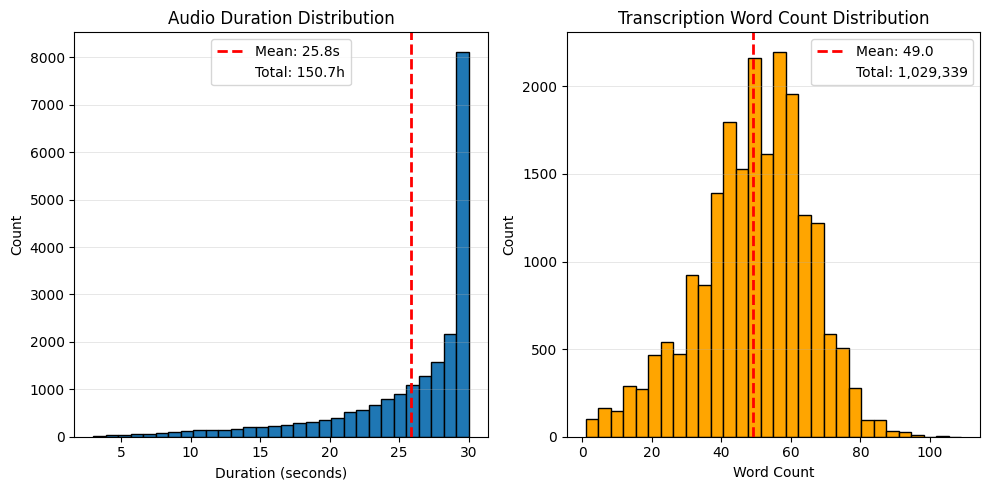

In [4]:
from scripts.dataset_plotting import plot_distribution_graphs

plot_distribution_graphs(all_data_df)

### Extract short random samples

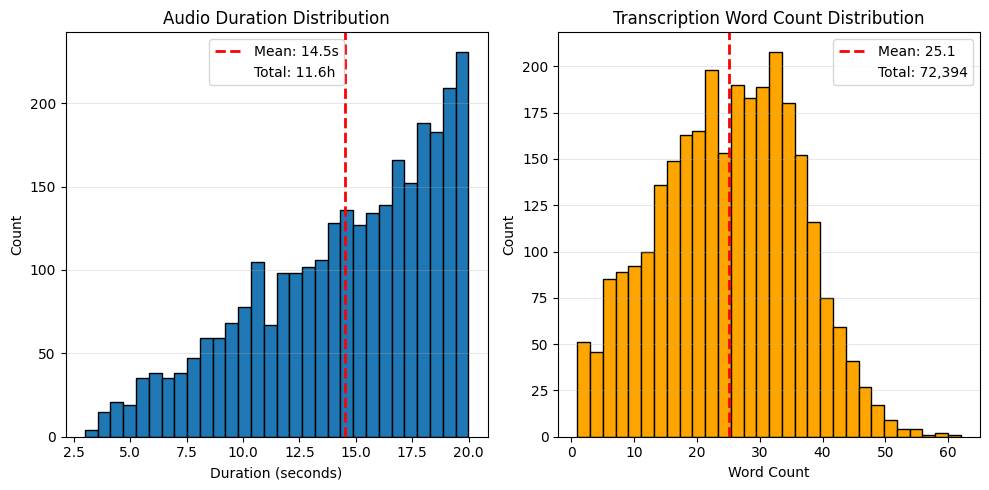

,text_original,path,duration,char_count,word_count
id,,,,,
3,darajadagi bilimlarni olishingiz mumkin ekan. ...,00003.wav,10.022875,126,15
9,keyin Naruto animesini ko'rganlar bo'lishi mum...,00009.wav,9.445375,101,13
17,"e-e Mana course bu kurs bo'lsa, curse degan so...",00017.wav,11.728000,81,15
22,nimaga hamma yangi chiqqan veb dasturlash kurs...,00022.wav,15.962687,241,31
34,am kereli narsalarni berdim. Ba'zi birlarni lo...,00034.wav,19.216000,253,32
...,...,...,...,...,...
21008,"Xo'p, JavaScript, aynan Node.jsni to'liq...",21008.wav,7.269375,43,5
21010,"o'ylashadi, lekin bu noto'g'ri fikr. Node.js s...",21010.wav,17.424000,202,22
21011,"Xo'p, undan keyin TypeScript, hozirgi kunda en...",21011.wav,16.837375,202,22


In [6]:
medium_audios = (all_data_df["duration"] <= 15)
long_audios = (all_data_df["duration"] > 15) & (all_data_df["duration"] <= 20)

medium_samples = all_data_df[medium_audios]
long_random_samples = all_data_df[long_audios].sample(1500, random_state=SEED)

sampled_df = pd.concat([medium_samples, long_random_samples]).sort_index()
sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

plot_distribution_graphs(sampled_df)

sampled_df

### Extract audios from parquet files to manually check the quality of the overall dataset 

In [7]:
import scripts.audio_preprocessing as ap

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

# Extract audios from parquet files
sample_ids = set(sampled_df.index.tolist())
print(f"Need to extract {len(sample_ids)} audio files")

# Create directory for extracted audio
os.makedirs(SAMPLED_AUDIO_DIR, exist_ok=True)

parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")

stats = []
found_count = 0
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    if found_count >= len(sample_ids):
        break

    df_partial = pd.read_parquet(parquet_file_path)
    df_partial["id"] = df_partial["id"].astype(int)
    df_partial.set_index("id", inplace=True)

    # Filter to only rows we need
    matching_rows = df_partial[df_partial.index.isin(sample_ids)]

    if len(matching_rows) < 1:
        del df_partial
        continue

    # Extract and normalize audios from parquet files
    audio_stats_partial_df = pd.DataFrame()
    for _, row in matching_rows.iterrows():
        audio_bytes = row["audio"]["bytes"]

        output_filename = row["audio"]["path"]
        output_path = os.path.join(SAMPLED_AUDIO_DIR, output_filename)

        waveform, stat = ap.process_audio_bytes(
            output_filename,
            audio_bytes,
            save_path=output_path,
            normalize=True,
            target_rms_db=-23.0,
            apply_highpass=True,
            highpass_cutoff=80.0,
            remove_silences=True,
            silence_threshold_db=-45.0,
            min_silence_duration=1.3
        )

        stats.append(stat)
        found_count += 1

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

processed_audio_stats_df = pd.DataFrame(stats)
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH, index=False)

print(f"\nExtracted and normalized {found_count} audio files to {SAMPLED_AUDIO_DIR}")
processed_audio_stats_df

Need to extract 2885 audio files
Found 35 parquet files. Started processing...



Processing files: 100%|██████████| 35/35 [01:50<00:00,  3.16s/it]


Extracted and normalized 2885 audio files to ../datasets/it_youtube_uzbek_speech_dataset/data/sampled_audio


,input_audio_filename,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude,is_clipped
0,04809.wav,-26.4974,-23.1393,12.197375,12.197375,0.0000,0.6003,False
1,04816.wav,-26.3045,-23.1942,16.464000,16.464000,0.0000,0.6239,False
2,04817.wav,-27.4594,-23.1742,8.656000,8.656000,0.0000,0.5956,False
3,04818.wav,-26.6990,-23.1465,19.002688,19.002688,0.0000,0.6561,False
4,04819.wav,-26.9482,-23.1517,15.034688,15.034688,0.0000,0.6335,False
...,...,...,...,...,...,...,...,...
2880,20311.wav,-24.2399,-23.2477,19.898688,19.898688,0.0000,0.6203,False
2881,20351.wav,-25.1289,-23.2311,18.576000,16.646000,1.9300,0.7542,False
2882,20380.wav,-26.9119,-23.4056,19.706875,15.810000,3.8969,0.8226,False
2883,20390.wav,-26.3377,-23.2382,19.077375,19.077375,0.0000,0.6240,False


In [8]:
processed_audio_stats_df.describe()

,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude
count,2885.000000,2885.000000,2885.000000,2885.000000,2885.000000,2885.000000
mean,-23.258891,-23.220529,14.513944,14.018775,0.495172,0.601034
std,4.009354,0.093939,4.078576,4.112710,1.041034,0.120026
min,-37.730100,-24.073600,2.989500,2.050000,0.000000,0.212300
25%,-25.876400,-23.257900,11.632000,11.130000,0.000000,0.518000
50%,-23.205600,-23.199600,15.290688,14.693375,0.000000,0.604300
75%,-20.977600,-23.158700,18.010687,17.446000,0.951500,0.686700
max,-8.516900,-23.066600,19.984000,19.984000,11.142900,0.906900


In [9]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
processed_audio_stats_df = pd.read_csv(PROCESSED_AUDIO_STATS_PATH)

old_total_duration = sampled_df["duration"].sum() / 3600
old_duration_mean = sampled_df["duration"].mean()

# --- Replace sampled_df.duration using processed_audio_stats_df.final_duration ---

# Merge final_duration into the sampled dataframe
sampled_df = sampled_df.merge(
    processed_audio_stats_df[["input_audio_filename", "final_duration"]],
    how="left",
    left_on="path",
    right_on="input_audio_filename"
)

# Replace duration only where we have final_duration
sampled_df["duration"] = (
    sampled_df["final_duration"].combine_first(sampled_df["duration"])
)

# Drop helper columns
sampled_df = sampled_df.drop(columns=["final_duration"])

# --- Remove suspiciously short and short recordings  ---

# Remove very short audios
mask_short_audio = (processed_audio_stats_df["final_duration"] < 3)
paths_to_remove = processed_audio_stats_df.loc[mask_short_audio, "input_audio_filename"].tolist()

total_reduced_duration = processed_audio_stats_df["reduced_duration"].sum() / 3600

# Remove these rows from processed stats
processed_audio_stats_df = processed_audio_stats_df[
    ~processed_audio_stats_df["input_audio_filename"].isin(paths_to_remove)
]

# Remove these recordings entirely
sampled_df = sampled_df[
    ~sampled_df["path"].isin(paths_to_remove)
]
print(f"{len(paths_to_remove)} recordings are removed from the sample")

# Updated totals
current_total_duration = processed_audio_stats_df["final_duration"].sum() / 3600
current_duration_mean = processed_audio_stats_df["final_duration"].mean()

# Save updated CSVs
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH)
sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

print(
    f"Before audio preprocessing: total duration - {old_total_duration:,.3f} h | mean {old_duration_mean:,.1f} s"
)
print(
    f"After audio preprocessing: total duration - {current_total_duration:,.3f} h "
    f"(reduced {total_reduced_duration * 60:.0f} min) | mean {current_duration_mean:,.1f} s"
)

sampled_df

7 recordings are removed from the sample
Before audio preprocessing: total duration - 11.631 h | mean 14.5 s
After audio preprocessing: total duration - 11.230 h (reduced 24 min) | mean 14.0 s


,text_original,path,duration,char_count,word_count,input_audio_filename
0,darajadagi bilimlarni olishingiz mumkin ekan. ...,00003.wav,9.050000,126,15,00003.wav
1,keyin Naruto animesini ko'rganlar bo'lishi mum...,00009.wav,9.445375,101,13,00009.wav
2,"e-e Mana course bu kurs bo'lsa, curse degan so...",00017.wav,11.728000,81,15,00017.wav
3,nimaga hamma yangi chiqqan veb dasturlash kurs...,00022.wav,15.962687,241,31,00022.wav
4,am kereli narsalarni berdim. Ba'zi birlarni lo...,00034.wav,19.216000,253,32,00034.wav
...,...,...,...,...,...,...
2880,"Xo'p, JavaScript, aynan Node.jsni to'liq...",21008.wav,7.269375,43,5,21008.wav
2881,"o'ylashadi, lekin bu noto'g'ri fikr. Node.js s...",21010.wav,17.424000,202,22,21010.wav
2882,"Xo'p, undan keyin TypeScript, hozirgi kunda en...",21011.wav,15.850000,202,22,21011.wav
2883,qarsaklar musiqa,21013.wav,13.520000,16,2,21013.wav


In [10]:
# Before running set your own PROJECT_ID to .env file (e.g. GOOGLE_CLOUD_PROJECT="your id here")
from pathlib import Path
from scripts import google_transcribe

# Prepare audio paths
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
audio_paths = sampled_df["path"].apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name)).tolist()

# Process files in parallel using two regions
print(f"Processing {len(audio_paths)} audio files using 2 regions (eu, us)...")
print("Starting parallel transcription...\n")

try:
    results = google_transcribe.transcribe_batch_parallel(
        audio_paths=audio_paths,
        regions=["eu", "us"],
        max_workers=12
    )
except Exception as err:
    print(f"\nCritical error during parallel processing: {type(err).__name__}: {err}")
    raise

# Process results
predicted_transcriptions = []
failed_count = 0
success_count = 0

for result in results:
    transcription_entry = {
        "path": Path(result["path"]).name,
        "predicted_sentence": result["predicted_sentence"],
        "error_message": result["error_message"],
        "error_type": result["error_type"],
    }

    predicted_transcriptions.append(transcription_entry)

    if result["predicted_sentence"] is not None:
        success_count += 1
    else:
        failed_count += 1

# Save results
predicted_transcripts_df = pd.DataFrame(predicted_transcriptions)
predicted_transcripts_df.to_csv(TRANSCRIPTION_RESULTS_PATH, index_label="id")
print(f"\nSaved transcription results to: {TRANSCRIPTION_RESULTS_PATH}")

print(f"\n{'=' * 60}")
print(f"Transcription Complete!")
print(f"{'=' * 60}")
print(f"✓ Successfully transcribed: {success_count}")
print(f"✗ Failed: {failed_count}")
print(f"Success rate: {success_count / len(sampled_df) * 100:.2f}%")

predicted_transcripts_df

Processing 2878 audio files using 2 regions (eu, us)...
Starting parallel transcription...



Transcribing: 100%|██████████| 2878/2878 [21:52<00:00,  2.19file/s]


Saved transcription results to: ../datasets/it_youtube_uzbek_speech_dataset/data/google_spt_transcriptions.csv

Transcription Complete!
✓ Successfully transcribed: 2877
✗ Failed: 1
Success rate: 99.97%


,path,predicted_sentence,error_message,error_type
0,00046.wav,"va qavs ichida aytyapman, murojaat qilayotgand...",None,None
1,00003.wav,darajadagi bilimlarni olishingiz mumkin ekan. ...,None,None
2,00009.wav,Keyin Naruto animestini ko'rganlar bo'lishi mu...,None,None
3,00091.wav,Karton movies sizni ozgina time-outga qo'yaman.,None,None
4,00085.wav,"tekshirish ham bo'lmaganda, shunaqa o'zaro uri...",None,None
...,...,...,...,...
2873,21010.wav,"o'ylashadi, lekin bu noto'g'ri fikr. Node.js s...",None,None
2874,20996.wav,Agar qanaqadir joyda xato gapirgan bo'lsam uzr...,None,None
2875,21011.wav,"Xo'p, undan keyin TypeScript hozirgi kunda eng...",None,None
2876,21016.wav,reja bilan boshlab olaman. Birinchi bo'lib taq...,None,None


In [11]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
predicted_transcripts_df = pd.read_csv(TRANSCRIPTION_RESULTS_PATH, index_col="id")

print(predicted_transcripts_df.info())

# Merge transcription results with original data
sampled_df = sampled_df.merge(
    predicted_transcripts_df,
    left_on="path",
    right_on="path",
    how="left"
)
sampled_df

<class 'pandas.core.frame.DataFrame'>
Index: 2878 entries, 0 to 2877
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   path                2878 non-null   object
 1   predicted_sentence  2809 non-null   object
 2   error_message       1 non-null      object
 3   error_type          1 non-null      object
dtypes: object(4)
memory usage: 112.4+ KB
None


,text_original,path,duration,char_count,word_count,input_audio_filename,predicted_sentence,error_message,error_type
0,darajadagi bilimlarni olishingiz mumkin ekan. ...,00003.wav,9.050000,126,15,00003.wav,darajadagi bilimlarni olishingiz mumkin ekan. ...,NaN,NaN
1,keyin Naruto animesini ko'rganlar bo'lishi mum...,00009.wav,9.445375,101,13,00009.wav,Keyin Naruto animestini ko'rganlar bo'lishi mu...,NaN,NaN
2,"e-e Mana course bu kurs bo'lsa, curse degan so...",00017.wav,11.728000,81,15,00017.wav,"course bu kurs bo'lsa, curse degan so'z bor, o...",NaN,NaN
3,nimaga hamma yangi chiqqan veb dasturlash kurs...,00022.wav,15.962687,241,31,00022.wav,Nimaga hamma yangi chiqqan veb-dasturlash kurs...,NaN,NaN
4,am kereli narsalarni berdim. Ba'zi birlarni lo...,00034.wav,19.216000,253,32,00034.wav,kerakli narsalarni berdim. Ba'zi birlarini loy...,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2873,"Xo'p, JavaScript, aynan Node.jsni to'liq...",21008.wav,7.269375,43,5,21008.wav,JavaScript aynan Node.js'ni to'liq,NaN,NaN
2874,"o'ylashadi, lekin bu noto'g'ri fikr. Node.js s...",21010.wav,17.424000,202,22,21010.wav,"o'ylashadi, lekin bu noto'g'ri fikr. Node.js s...",NaN,NaN
2875,"Xo'p, undan keyin TypeScript, hozirgi kunda en...",21011.wav,15.850000,202,22,21011.wav,"Xo'p, undan keyin TypeScript hozirgi kunda eng...",NaN,NaN
2876,qarsaklar musiqa,21013.wav,13.520000,16,2,21013.wav,NaN,NaN,NaN


In [12]:


sampled_df.drop(columns=["error_message", "error_type", "input_audio_filename"], inplace=True, errors="ignore")
sampled_df.rename(columns={"predicted_sentence": "text_spt"}, inplace=True)

# Reorder text_original column to be the last column
cols = list(sampled_df.columns)
cols.remove("text_original")
cols.append("text_original")
sampled_df = sampled_df[cols]

# Apply similarity metrics to each row
metrics = sampled_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["text_spt"],  # Google SPT generated text (should be more accurate)
        hypothesis=row["text_original"],  # original Gemini 2.5 Pro generated text
    ),
    axis=1
)

# Convert list of dicts → DataFrame
metrics_df = pd.DataFrame(metrics.tolist())

# Merge metric columns back into main DataFrame and save
sampled_df = pd.concat([sampled_df, metrics_df], axis=1)

sampled_df.sort_values("wer", ascending=False)

,path,duration,char_count,word_count,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
1767,13028.wav,16.360000,289,46,NaN,"bu ham billing, to'g'rimi? Ha, bu yerda keyin ...",,bu ham billing to'g'rimi ha bu yerda keyin har...,46.0,277.0,0.0,0,46
1955,14853.wav,17.093375,226,37,NaN,"Sobstvenno, chto takoye LinkedIn, da? kak raz,...",,sobstvenno chto takoye linkedin da kak raz kak...,37.0,213.0,0.0,0,37
1950,14837.wav,14.213375,219,37,NaN,"a yesli vi New York, naprimer, da? I on dumaye...",,a yesli vi new york naprimer da i on dumayet y...,37.0,208.0,0.0,0,37
1311,09355.wav,16.624000,206,36,NaN,"jizni, kotoriye realno rabotayut.\nTo yest, ye...",,jizni kotoriye realno rabotayut to yest yest p...,36.0,194.0,0.0,0,36
421,03269.wav,16.410688,276,35,NaN,chambarchas bog'lanib ketadi. Keyin mana biz p...,,chambarchas bog'lanib ketadi keyin mana biz pa...,35.0,272.0,0.0,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,14731.wav,12.336000,151,22,Project manager shaxs bu bo'yicha o'rta daraja...,project manager shaxs bu boʻyicha oʻrta daraja...,project manager shaxs bu bo'yicha o'rta daraja...,project manager shaxs bu bo'yicha o'rta daraja...,0.0,0.0,1.0,22,22
1925,14681.wav,7.941375,98,11,Bu degani tepadagi bilan solishtiramiz. Projec...,bu degani tepadagi bilan solishtiramiz. Projec...,bu degani tepadagi bilan solishtiramiz project...,bu degani tepadagi bilan solishtiramiz project...,0.0,0.0,1.0,11,11
1910,14604.wav,6.330687,59,8,"o'zidan ta'sir qiladi, ayniqsa bu fikrlashga t...","oʻzidan taʼsir qiladi, ayniqsa bu fikrlashga t...",o'zidan ta'sir qiladi ayniqsa bu fikrlashga ta...,o'zidan ta'sir qiladi ayniqsa bu fikrlashga ta...,0.0,0.0,1.0,8,8
1900,14528.wav,16.320000,232,30,Ustoz bilan o'rganish u yoki bu darajada to'xt...,Ustoz bilan o'rganish u yoki bu darajada to'xt...,ustoz bilan o'rganish u yoki bu darajada to'xt...,ustoz bilan o'rganish u yoki bu darajada to'xt...,0.0,0.0,1.0,30,30


In [13]:
music_annotation_mask = (sampled_df["text_spt"].isna()) & (sampled_df["hyp_normalized"].isin(["[musiqa]", "(musiqa)"]))

# Update text columns
cols_to_fix = ["text_spt", "ref_normalized", "hyp_normalized"]
sampled_df.loc[music_annotation_mask, cols_to_fix] = "[musiqa]"

# Update the numeric columns
sampled_df.loc[music_annotation_mask, ["wer", "cer", "sequence_similarity"]] = 0.0

sampled_df.describe()

,duration,char_count,word_count,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,2878.000000,2878.000000,2878.000000,2878.000000,2878.000000,2878.000000,2878.000000,2878.000000
mean,14.046756,187.590688,25.149757,0.620649,3.110365,0.852899,24.344684,25.278318
std,4.078289,79.323118,10.803333,3.402839,23.233037,0.251465,19.939604,10.866813
min,3.150000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,11.162688,129.000000,17.000000,0.055600,0.014400,0.861350,16.000000,17.000000
50%,14.714094,192.000000,26.000000,0.120000,0.041000,0.962650,25.000000,26.000000
75%,17.450000,249.000000,33.000000,0.222200,0.092300,0.989175,32.000000,33.000000
max,19.984000,426.000000,62.000000,46.000000,277.000000,1.000000,905.000000,62.000000


In [24]:
# Remove very poor alignment (wer > 10%)
sampled_df = sampled_df[sampled_df["wer"] <= 0.10]
sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

aligned_mask = sampled_df["wer"] == 0.0
len_aligned_recordings = len(sampled_df[aligned_mask])
aligned_duration = sampled_df[aligned_mask]["duration"].sum() / 3600

total_recordings = len(sampled_df)
not_aligned_duration = sampled_df[~aligned_mask]["duration"].sum() / 3600

print(f"Total duration of the sample: {sampled_df["duration"].sum() / 3600:.2f} hours")
print(
    f"Audio and transcription aligned recordings: {len_aligned_recordings:,} - {aligned_duration:.2f} hours")
print(
    f"Remaining recordings: {total_recordings - len_aligned_recordings:,} - {not_aligned_duration:.2f} hours")
sampled_df.describe()

Total duration of the sample: 4.99 hours
Audio and transcription aligned recordings: 354 - 1.16 hours
Remaining recordings: 903 - 3.83 hours


,duration,char_count,word_count,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000
mean,14.285600,192.712808,25.774065,0.044290,0.017277,0.947904,25.675418,25.901352
std,4.014468,77.366514,10.504088,0.033617,0.019148,0.153005,10.529212,10.562589
min,3.194688,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,11.632000,142.000000,19.000000,0.000000,0.000000,0.976900,18.000000,19.000000
50%,14.992000,201.000000,26.000000,0.045500,0.012100,0.990700,26.000000,27.000000
75%,17.620000,252.000000,33.000000,0.073200,0.026300,1.000000,33.000000,34.000000
max,19.984000,382.000000,62.000000,0.100000,0.145200,1.000000,61.000000,62.000000


In [25]:
import glob

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

all_audio_paths = set(glob.glob(os.path.join(SAMPLED_AUDIO_DIR, "*.wav")))
audio_paths_to_keep = set(
    sampled_df["path"]
    .apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name))
)
audio_paths_to_remove = all_audio_paths - audio_paths_to_keep

for path in audio_paths_to_remove:
    os.remove(path)

print(f"Removed unnecessary {len(audio_paths_to_remove):,} audio files")

Removed unnecessary 1,628 audio files


In [28]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

interested_cols = ["path", "text_spt", "text_original", "ref_normalized", "hyp_normalized", "wer",
                   "sequence_similarity", "duration"]
misaligned_df = sampled_df[sampled_df["wer"] > 0]
random_sample = misaligned_df.sample(200, random_state=SEED)

# Get the Top WER Sample (excluding the random ones)
top_wer_sample = misaligned_df.drop(random_sample.index).nlargest(50, "wer")

to_manually_check_df = pd.concat([random_sample, top_wer_sample])[interested_cols]
to_manually_check_df.to_csv(os.path.join(DATASET_DIR, "check_alignment_manually.csv"), index_label="id")
print(f"Total duration to be manually checked: {to_manually_check_df["duration"].sum() / 3600:.2f} hours")
to_manually_check_df

Total duration to be manually checked: 1.04 hours


,path,text_spt,text_original,ref_normalized,hyp_normalized,wer,sequence_similarity,duration
id,,,,,,,,
1905,14568.wav,Mana hozir istalgan o'quvchini istalgan ma'lum...,"Mana hozir istalgan o'quvchini, istalgan ma'lu...",mana hozir istalgan o'quvchini istalgan ma'lum...,mana hozir istalgan o'quvchini istalgan ma'lum...,0.0588,0.9692,19.365375
2299,17141.wav,"joylab watch sass tugmasini bosadigan bo'lsak,...","joylab, watch SAS tugmasini bosadigan boʻlsak,...",joylab watch sass tugmasini bosadigan bo'lsak ...,joylab watch sas tugmasini bosadigan bo'lsak m...,0.0417,0.9968,12.350000
1533,11139.wav,email joylaymiz. Ular orqali ham biz o'sha mas...,"email jo'natamiz. Ular orqali ham biz o'sha, e...",email joylaymiz ular orqali ham biz o'sha masa...,email jo'natamiz ular orqali ham biz o'sha e-e...,0.0645,0.8522,17.413375
1772,13073.wav,Burnoutdan siz umuman uzoqlashib chiqasiz. Umu...,burnoutdan siz umuman uzoqlashib chiqasiz. Umu...,burnoutdan siz umuman uzoqlashib chiqasiz umum...,burnoutdan siz umuman uzoqlashib chiqasiz umum...,0.0294,0.9982,18.608000
2600,18940.wav,blankada o'zinglar haqinglarda ma'lumot to'ldi...,shu blankada oʻzinglar haqinglarda maʼlumot to...,blankada o'zinglar haqinglarda ma'lumot to'ldi...,shu blankada o'zinglar haqinglarda ma'lumot to...,0.0667,0.9833,7.860000
...,...,...,...,...,...,...,...,...
1446,10371.wav,Faqat o'zi bu dasturlash tilini bitta qiziq ta...,Faqat oʻzi bu dasturlash tilini bitta qiziq ta...,faqat o'zi bu dasturlash tilini bitta qiziq ta...,faqat o'zi bu dasturlash tilini bitta qiziq ta...,0.0968,0.9653,12.150000
1472,10510.wav,talabalarni bilimini doimiy tekshirib borishga...,ikkinchidan talabalarni bilimini doimiy tekshi...,talabalarni bilimini doimiy tekshirib borishga...,ikkinchidan talabalarni bilimini doimiy tekshi...,0.0968,0.6128,12.229313
2134,16074.wav,hammasi sun'iy intellekt yordamida. Endi bu 17...,hamma sun'iy intellekt yordamida. endi bu bir ...,hammasi sun'iy intellekt yordamida endi bu bir...,hamma sun'iy intellekt yordamida endi bu bir y...,0.0968,0.9720,13.850687


In [5]:
import scripts.similarity_metrics as similarity_metrics

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
checked_df = pd.read_csv(os.path.join(DATASET_DIR, "it_dataset_checked.csv"), index_col="id")

paths_to_remove = checked_df[checked_df["sentence_checked"].isna()]["path"]
checked_df = checked_df[~checked_df["path"].isin(paths_to_remove)]
sampled_df = sampled_df[~sampled_df["path"].isin(paths_to_remove)]

sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

google_spt_metrics = checked_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence_checked"],
        hypothesis=row["text_spt"],  # Google SPT generated text
    ),
    axis=1
)
google_spt_metrics = pd.DataFrame(google_spt_metrics.tolist(), checked_df.index)

gemini_metrics = checked_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence_checked"],
        hypothesis=row["text_original"],  # Gemini 2.5 Pro generated text
    ),
    axis=1
)
gemini_metrics = pd.DataFrame(gemini_metrics.tolist(), checked_df.index)

print(f"Manually checked total duration: {checked_df["duration"].sum() / 3600:.2f} hours")
print(f"Original WER - Google SPT to Gemini 2.5 Pro: {checked_df["wer"].mean() * 100:.2f}%")
print(f"Estimated WER of Google SPT: {google_spt_metrics["wer"].mean() * 100:.2f}%")
print(f"Estimated WER of Gemini 2.5 Pro: {gemini_metrics["wer"].mean() * 100:.2f}%")

google_spt_metrics.sort_values("wer", ascending=False)

Manually checked total duration: 0.99 hours
Original WER - Google SPT to Gemini 2.5 Pro: 6.85%
Estimated WER of Google SPT: 3.84%
Estimated WER of Gemini 2.5 Pro: 4.46%


,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
id,,,,,,,
1204,tashrif buyurdim va bu yerda kunim taassurotla...,tashrif buyurdim va bu yerda juda ham taassuro...,0.1724,0.0914,0.9415,29,30
1542,lekin o'zlari qilinmaydi biz buni aytishimga s...,lekin o'zlari qilinmaydi biz buni aytishimga s...,0.1579,0.0671,0.9574,19,21
919,masalan aniq bir arxitektura biron-bir narsa u...,masalan aniq bir arxitektura biror bir narsa u...,0.1333,0.0179,0.9865,30,31
2494,yigirma million to'g'ri yigirma million endi t...,yigirma milliard to'g'ri yigirma milliard taqq...,0.1290,0.0672,0.8505,31,30
1503,keyin o'sha sertifikatlarni olib boshqa qilib ...,keyin o'sha sertifikatlarni olib olib boshqa q...,0.1290,0.0437,0.7380,31,32
...,...,...,...,...,...,...,...
1899,va ko'p menejerlarga ular tasdiqlash uchun oli...,va ko'p menejerlarga ular tasdiqlash uchun oli...,0.0000,0.0000,1.0000,20,20
1397,kattakon rahmat ustozlar mansur aka anvar aka ...,kattakon rahmat ustozlar mansur aka anvar aka ...,0.0000,0.0000,1.0000,30,30
2642,brauzerga aytamiz biz yozgan hujjat html besh ...,brauzerga aytamiz biz yozgan hujjat html besh ...,0.0000,0.0000,1.0000,20,20


In [6]:
from sklearn.model_selection import train_test_split

checked_df.drop(columns=["text_spt", "ref_normalized", "hyp_normalized", "wer", "sequence_similarity"],
                inplace=True)
checked_df.rename(columns={"sentence_checked": "text_spt"}, inplace=True)

# Merge Google Gemini results
checked_df = pd.concat([checked_df, gemini_metrics], axis=1)

# Split manually checked dataset into validation and test sets
val_df, test_df = train_test_split(checked_df, test_size=0.5, random_state=SEED)

# Label the subsets
val_df = val_df.assign(type="validation")
test_df = test_df.assign(type="test")

# Merge back into the original variable name
checked_df = pd.concat([val_df, test_df])

# Reorder columns
cols = list(checked_df.columns)
cols.remove("text_original")
cols.remove("type")
cols.insert(3, "text_original")
cols.insert(2, "type")
checked_df = checked_df[cols]

print(f"Validation set duration: {val_df["duration"].sum() / 60:.0f} minutes")
print(f"Test set duration: {test_df["duration"].sum() / 60:.0f} minutes")

checked_df.to_csv(VALIDATION_TEST_SETS_PATH, index_label="id")
checked_df

Validation set duration: 29 minutes
Test set duration: 30 minutes


,path,duration,type,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
id,,,,,,,,,,,,
868,05915.wav,18.010687,validation,kul rang rangda bo'lishi kerak ekan va endi bu...,kulrang rangda boʻlishi kerak ekan. Va endi bu...,kul rang rangda bo'lishi kerak ekan va endi bu...,kulrang rangda bo'lishi kerak ekan va endi bun...,0.0833,0.0174,0.3144,36,35
588,04415.wav,16.784000,validation,ishga to'g'ri keladi. Buni hammasi ko'proq nar...,ishga to'g'ri keladi. buni hammasi ko'proq nar...,ishga to'g'ri keladi buni hammasi ko'proq nars...,ishga to'g'ri keladi buni hammasi ko'proq nars...,0.0357,0.0332,0.9837,28,29
949,06536.wav,16.050000,validation,"nima qilasizlar, shunday kommentariyaga o'zing...","nima qilasizlar, shunday kommentariyaga oʻzing...",nima qilasizlar shunday kommentariyaga o'zingl...,nima qilasizlar shunday kommentariyaga o'zingl...,0.0541,0.0180,0.9910,37,37
1419,10207.wav,13.317312,validation,Endi design with Figma and whiteboard with Fig...,"Endi design with Figma, um, and whiteboard wit...",endi design with figma and whiteboard with fig...,endi design with figma um and whiteboard with ...,0.0526,0.0231,0.9886,19,20
2466,18154.wav,19.408000,validation,Juda ham muhim firibgarlarga qarshi kurashish ...,juda ham muhim. Firibgarlarga qarshi kurashish...,juda ham muhim firibgarlarga qarshi kurashish ...,juda ham muhim firibgarlarga qarshi kurashish ...,0.0208,0.0057,0.9971,48,49
...,...,...,...,...,...,...,...,...,...,...,...,...
344,02535.wav,12.442687,test,O'sha nimani bilmasligini bilish bosim ostida ...,o'sha nimani bilmasligini bilish bosim ostida ...,o'sha nimani bilmasligini bilish bosim ostida ...,o'sha nimani bilmasligini bilish bosim ostida ...,0.0500,0.0276,0.9864,20,21
594,04433.wav,12.370000,test,holati eslatadi. Hozir Amerikada motellar bu k...,"holati eslatadi. hozir Amerikada motellar, bu ...",holati eslatadi hozir amerikada motellar bu ki...,holati eslatadi hozir amerikada motellar bu ki...,0.0000,0.0000,1.0000,17,17
2042,15508.wav,17.978687,test,"dastur shakliga olib kelib, shogirdlarimizga t...","dastur shakliga olib kelib, shogirdlarimizga t...",dastur shakliga olib kelib shogirdlarimizga ta...,dastur shakliga olib kelib shogirdlarimizga ta...,0.0455,0.0479,0.9657,22,22


In [7]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
val_test_df = pd.read_csv(VALIDATION_TEST_SETS_PATH, index_col="id")

# Remove samples that already belong to validation or test sets
sampled_df = sampled_df[~sampled_df["path"].isin(val_test_df["path"])]
sampled_df["type"] = "train"

sampled_df = pd.concat([sampled_df, val_test_df])

# Reorder columns
cols = list(sampled_df.columns)
cols.remove("type")
cols.insert(2, "type")
sampled_df = sampled_df[cols]

sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")
sampled_df.describe()

,duration,char_count,word_count,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,1245.000000,1007.000000,1007.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000
mean,14.272127,189.142006,25.310824,0.039552,0.015091,0.952612,25.638554,25.839357
std,4.022528,79.532435,10.824725,0.033676,0.017483,0.150333,10.529447,10.560341
min,3.194688,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,11.620000,135.000000,17.500000,0.000000,0.000000,0.979700,18.000000,19.000000
50%,14.981375,197.000000,26.000000,0.040000,0.010200,0.992900,26.000000,26.000000
75%,17.620000,251.000000,33.000000,0.066700,0.023800,1.000000,33.000000,34.000000
max,19.984000,382.000000,62.000000,0.181800,0.133300,1.000000,61.000000,62.000000


In [8]:
print(f"Total sampled duration: {sampled_df["duration"].sum() / 3600:.2f}h")
(sampled_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False)

Total sampled duration: 4.94h


type
train         3.950023
test          0.496710
validation    0.489044
Name: duration, dtype: float64

In [3]:
from scripts.audio_augmentation import augment_dataset, AugmentationType

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
train_mask = sampled_df["type"] == "train"
previous_sample_to_augment = sampled_df[train_mask]

audio_paths = previous_sample_to_augment["path"].apply(
    lambda filename: os.path.join(SAMPLED_AUDIO_DIR, filename)).tolist()

augmentation_types = [
    AugmentationType.SPEED | AugmentationType.NOISE,
    AugmentationType.PITCH | AugmentationType.TIME_MASK,
]

augmentation_df = augment_dataset(
    audio_paths,
    SAMPLED_AUDIO_DIR,
    augmentation_types,
    noise_prob=0.7,
    time_mask_prob=0.7,
    min_speed_rate=0.9,
    max_speed_rate=1.1
)
augmentation_df.to_csv(os.path.join(DATASET_DIR, "augmentation_log.csv"), index_label="id")
augmentation_df

Processing files...: 100%|██████████| 1007/1007 [01:17<00:00, 13.04it/s]


Saved log to ../datasets/it_youtube_uzbek_speech_dataset/data/sampled_audio/augmentation_log.csv


,original_path,augmented_path,original_duration,augmented_duration,speed_applied,speed_rate_applied,pitch_applied,noise_applied,time_mask_applied,augmentation_type
0,00003.wav,00003_augmented_spd_nse.wav,9.0500,9.2888,True,0.9743,False,False,False,AugmentationType.SPEED|NOISE
1,00003.wav,00003_augmented_pch_msk.wav,9.0500,9.0500,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
2,00139.wav,00139_augmented_spd_nse.wav,13.6587,14.5276,True,0.9402,False,False,False,AugmentationType.SPEED|NOISE
3,00139.wav,00139_augmented_pch_msk.wav,13.6587,13.6587,False,1.0000,True,False,False,AugmentationType.PITCH|TIME_MASK
4,00140.wav,00140_augmented_spd_nse.wav,16.1227,17.3074,True,0.9316,False,True,False,AugmentationType.SPEED|NOISE
...,...,...,...,...,...,...,...,...,...,...
2009,20867.wav,20867_augmented_pch_msk.wav,8.7733,8.7733,False,1.0000,True,False,False,AugmentationType.PITCH|TIME_MASK
2010,21010.wav,21010_augmented_spd_nse.wav,17.4240,19.0427,True,0.9150,False,True,False,AugmentationType.SPEED|NOISE
2011,21010.wav,21010_augmented_pch_msk.wav,17.4240,17.4240,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
2012,21016.wav,21016_augmented_spd_nse.wav,19.4294,20.4761,True,0.9489,False,True,False,AugmentationType.SPEED|NOISE


In [6]:
augmentation_df = pd.read_csv(os.path.join(DATASET_DIR, "augmentation_log.csv"))

previous_sample_to_augment["type"] = "train"
sampled2_df = previous_sample_to_augment.merge(
    augmentation_df,
    left_on="path",
    right_on="original_path",
    how="left"
)

sampled2_df.drop(columns=["duration", "original_duration", "original_path", "path", "id"], inplace=True)
sampled2_df.rename(columns={"augmented_path": "path", "augmented_duration": "duration"}, inplace=True)

cols = list(sampled2_df.columns)
cols.remove("path")
cols.insert(0, "path")
cols.remove("duration")
cols.insert(2, "duration")
sampled2_df = sampled2_df[cols]

sampled2_df = sampled2_df[sampled2_df["duration"] < 30]

sampled2_df.to_csv(os.path.join(DATASET_DIR, "sampled2.csv"), index_label="id")
sampled2_df

/tmp/ipykernel_24497/558727315.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previous_sample_to_augment["type"] = "train"


,path,type,duration,char_count,word_count,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count,speed_applied,speed_rate_applied,pitch_applied,noise_applied,time_mask_applied,augmentation_type
0,00003_augmented_spd_nse.wav,train,9.2888,126.0,15.0,darajadagi bilimlarni olishingiz mumkin ekan. ...,darajadagi bilimlarni olishingiz mumkin ekan. ...,darajadagi bilimlarni olishingiz mumkin ekan m...,darajadagi bilimlarni olishingiz mumkin ekan m...,0.0667,0.0244,0.9756,15,15,True,0.9743,False,False,False,AugmentationType.SPEED|NOISE
1,00003_augmented_pch_msk.wav,train,9.0500,126.0,15.0,darajadagi bilimlarni olishingiz mumkin ekan. ...,darajadagi bilimlarni olishingiz mumkin ekan. ...,darajadagi bilimlarni olishingiz mumkin ekan m...,darajadagi bilimlarni olishingiz mumkin ekan m...,0.0667,0.0244,0.9756,15,15,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
2,00139_augmented_spd_nse.wav,train,14.5276,126.0,19.0,kerak bo'ladi. Bu haqida aytib oldim. Endi tad...,kerak boʻladi. Bu haqida aytib oldim. endi tad...,kerak bo'ladi bu haqida aytib oldim endi tadqi...,kerak bo'ladi bu haqida aytib oldim endi tadqi...,0.0556,0.0431,0.9789,18,19,True,0.9402,False,False,False,AugmentationType.SPEED|NOISE
3,00139_augmented_pch_msk.wav,train,13.6587,126.0,19.0,kerak bo'ladi. Bu haqida aytib oldim. Endi tad...,kerak boʻladi. Bu haqida aytib oldim. endi tad...,kerak bo'ladi bu haqida aytib oldim endi tadqi...,kerak bo'ladi bu haqida aytib oldim endi tadqi...,0.0556,0.0431,0.9789,18,19,False,1.0000,True,False,False,AugmentationType.PITCH|TIME_MASK
4,00140_augmented_spd_nse.wav,train,17.3074,162.0,23.0,Keyin qanaqa qilib GitHubda e'tibor tortish mu...,keyin qanaqa qilib Githubda e'tibor tortish mu...,keyin qanaqa qilib githubda e'tibor tortish mu...,keyin qanaqa qilib githubda e'tibor tortish mu...,0.0455,0.0130,0.9935,22,23,True,0.9316,False,True,False,AugmentationType.SPEED|NOISE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,20867_augmented_pch_msk.wav,train,8.7733,116.0,14.0,qismi bo'ladimi? Bu qismiga siz dasturchi sifa...,qismi bo'ladimi? Bu qismiga siz dasturchi sifa...,qismi bo'ladimi bu qismiga siz dasturchi sifat...,qismi bo'ladimi bu qismiga siz dasturchi sifat...,0.0000,0.0000,1.0000,14,14,False,1.0000,True,False,False,AugmentationType.PITCH|TIME_MASK
2010,21010_augmented_spd_nse.wav,train,19.0427,202.0,22.0,"o'ylashadi, lekin bu noto'g'ri fikr. Node.js s...","o'ylashadi, lekin bu noto'g'ri fikr. Node.js s...",o'ylashadi lekin bu noto'g'ri fikr node js shu...,o'ylashadi lekin bu noto'g'ri fikr node js shu...,0.0000,0.0000,1.0000,23,23,True,0.9150,False,True,False,AugmentationType.SPEED|NOISE
2011,21010_augmented_pch_msk.wav,train,17.4240,202.0,22.0,"o'ylashadi, lekin bu noto'g'ri fikr. Node.js s...","o'ylashadi, lekin bu noto'g'ri fikr. Node.js s...",o'ylashadi lekin bu noto'g'ri fikr node js shu...,o'ylashadi lekin bu noto'g'ri fikr node js shu...,0.0000,0.0000,1.0000,23,23,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
2012,21016_augmented_spd_nse.wav,train,20.4761,256.0,31.0,reja bilan boshlab olaman. Birinchi bo'lib taq...,"reja bilan boshlab olaman. Birinchi bo'lib, ta...",reja bilan boshlab olaman birinchi bo'lib taqd...,reja bilan boshlab olaman birinchi bo'lib taqd...,0.0000,0.0000,1.0000,32,32,True,0.9489,False,True,False,AugmentationType.SPEED|NOISE


In [8]:
(sampled2_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False)

type
train    7.929865
Name: duration, dtype: float64